In [2]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Can use simpler methods for fitting data for just one wavelength

In [3]:
data_dir = 'training_data/single_wave/'
all_data = glob.glob(os.path.join(data_dir, "*.csv"))
combined_data = pd.concat([pd.read_csv(file) for file in all_data], ignore_index=True)
combined_data.drop(["Unnamed: 0"], axis = 1)

,Wavelength,V1,V2,Gain,Out
0,490,0.600000,0.600000,4,-0.245645
1,490,0.684685,0.600000,4,-0.245820
2,490,0.769369,0.600000,4,-0.246121
3,490,0.854054,0.600000,4,-0.246086
4,490,0.938739,0.600000,4,-0.246285
...,...,...,...,...,...
1830,490,1.037209,9.562791,4,-0.110316
1831,490,0.927907,9.672093,4,-0.098668
1832,490,0.818605,9.781395,4,-0.098445
1833,490,0.709302,9.890698,4,-0.090430


In [4]:
x = combined_data['V1']
y = combined_data['V2']
z = combined_data['Out']

Raw data plot

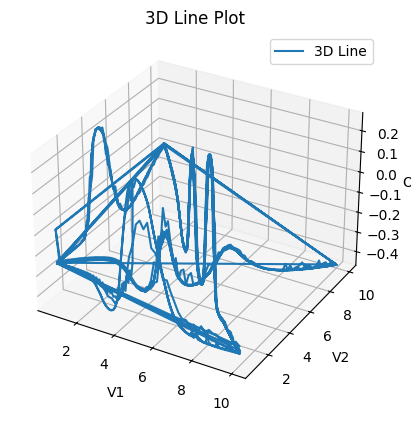

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, label='3D Line')

ax.set_xlabel('V1')
ax.set_ylabel('V2')
ax.set_zlabel('Out')
ax.set_title('3D Line Plot')
ax.legend()

plt.show()


That's an interesting relationship. Going to do a more intense grid search for best fitting parameters

In [30]:
X = np.column_stack((x, y))

c_vals = np.linspace(414,418,20)
gamma_vals = np.linspace(0.63,0.66,20)

param_grid = {'C': c_vals, 'gamma': gamma_vals}
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X, z)
best_c = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
print(grid_search.best_params_)


{'C': 416.5263157894737, 'gamma': 0.6457894736842106}


In [34]:

model = SVR(kernel='rbf', C=best_c, gamma=best_gamma) 
model.fit(X,z)

x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1 


xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 1000),
                       np.linspace(x2_min, x2_max, 1000))


xx_input = np.column_stack((xx1.ravel(), xx2.ravel()))

y_pred = model.predict(xx_input)

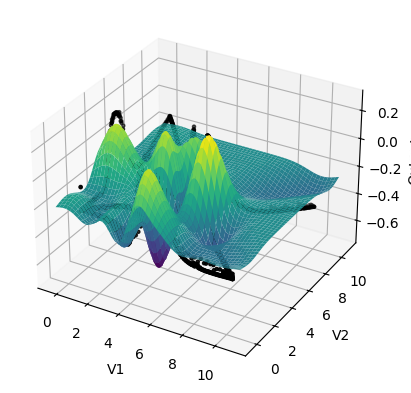

In [35]:
y_pred = y_pred.reshape(xx1.shape)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(xx1, xx2, y_pred, cmap='viridis')

ax.scatter(X[:,0], X[:,1], z, c='black', marker='.')

# Labels
ax.set_xlabel('V1')
ax.set_ylabel('V2')
ax.set_zlabel('Output')

plt.show()

In [33]:
model.predict(5,5)

TypeError: BaseLibSVM.predict() takes 2 positional arguments but 3 were given

## What if we rescale to actually be an angle (not voltage?)

In [37]:
combined_data['Out'].min()

-0.4549296875

In [45]:
range = combined_data['Out'].max() - combined_data['Out'].min()
scale = 90/range
offset = abs(combined_data['Out'].min())
combined_data['Angle'] = (combined_data['Out'] + offset)*scale

In [46]:
combined_data['Angle']

0       25.927700
1       25.905923
2       25.868660
3       25.873016
4       25.848335
          ...    
1830    42.693089
1831    44.136179
1832    44.163763
1833    45.156794
1834    45.473771
Name: Angle, Length: 1835, dtype: float64

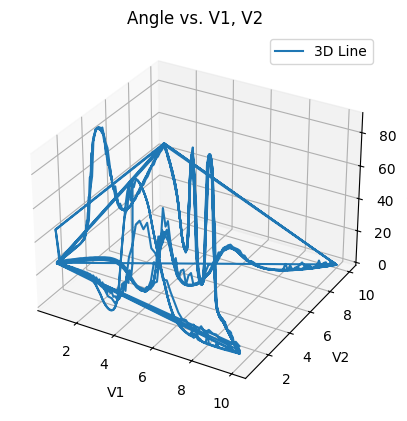

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, combined_data['Angle'], label='3D Line')

ax.set_xlabel('V1')
ax.set_ylabel('V2')
ax.set_zlabel('Angle')
ax.set_title('Angle vs. V1, V2')
ax.legend()

plt.show()

In [54]:
low_v1 = combined_data[combined_data['V1'] == 0.6]

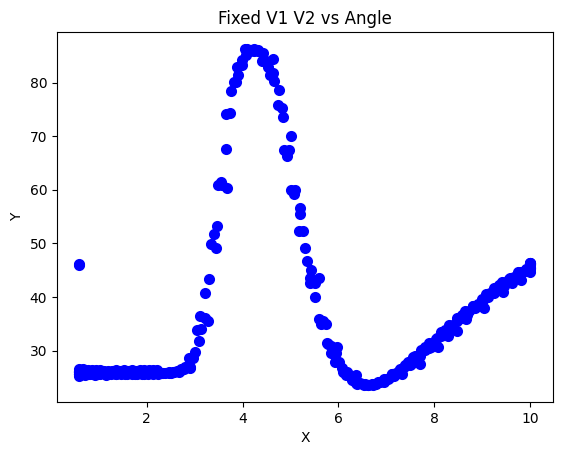

In [60]:
lowv1x = low_v1['V2']
lowv1y = low_v1['Angle']

fig, ax = plt.subplots()

ax.scatter(lowv1x, lowv1y, color='blue', linewidth=2)

# Customization
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Fixed V1 V2 vs Angle')

# Show!
plt.show()


I have an idea for the single wavelength polarization... If there's a given V1 which can achieve any arbitrary polarization angle (i.e. a half wave for linear?) Then that's all that matters for that calibration. Can search the V1 vals to see if any have an output ranging from 0 to 90

In [116]:
ranges = []
v1_vals = combined_data['V1'].unique()
for val in v1_vals:
    axis = combined_data[combined_data['V1'] == val]
    max = axis['Angle'].max()
    min = axis['Angle'].min()
    if max-min > 60:
        ranges.append([max-min,val,len(axis)])

In [117]:
np.where(ranges == np.max(ranges))
ranges[4][1]
ranges

[[62.67615176151761, 0.6, 267],
 [64.74641889276035, 4.495495495495496, 4],
 [71.16144018583043, 4.5801801801801805, 4],
 [77.29384436701508, 4.664864864864865, 4],
 [78.301393728223, 4.74954954954955, 4],
 [88.36285327138985, 4.834234234234234, 4],
 [82.68776616337591, 4.918918918918919, 4],
 [80.54103755323267, 5.003603603603604, 4],
 [87.06494386372435, 5.088288288288289, 4],
 [84.72125435540069, 5.172972972972973, 4],
 [82.49032133178476, 5.257657657657658, 4],
 [79.58236546651182, 5.342342342342342, 4],
 [76.65989159891599, 5.427027027027028, 4],
 [72.01074332171893, 5.511711711711712, 4],
 [65.96883468834687, 5.596396396396397, 4],
 [63.58739837398374, 6.273873873873874, 4],
 [65.00048393341075, 6.358558558558559, 4],
 [69.94483159117306, 6.443243243243243, 4],
 [72.02768099109562, 6.527927927927928, 4],
 [73.3531746031746, 6.612612612612613, 4],
 [71.34049554781262, 6.697297297297298, 4],
 [72.12785520712349, 6.781981981981982, 4],
 [63.841463414634134, 6.866666666666667, 8],
 [

88.96 is very close, likely workable

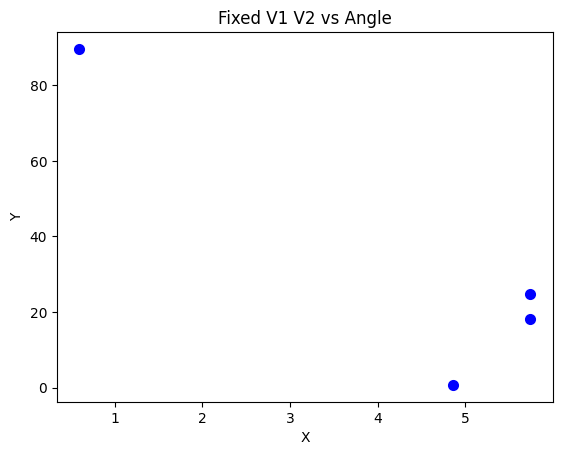

In [109]:
#max_range_entry = max(ranges, key=lambda item: item['Range'])

culled_data = combined_data[combined_data['V1'] == ranges[4][1]]

cutx = culled_data['V2']
cuty = culled_data['Angle']

fig, ax = plt.subplots()

ax.scatter(cutx, cuty, color='blue', linewidth=2)

# Customization
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Fixed V1 V2 vs Angle')

# Show!
plt.show()

It's a small data set... But I will scan over this tomorrow and see the potential